In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from keras.models import load_model
from sklearn.metrics import confusion_matrix

/home/ericakcc/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# function of plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# path
dir_ = '../data/'

all_data = os.listdir(dir_)
for file in all_data:
    if "ATM" in file:
        all_data.remove(file)

In [19]:
# loading data
data = np.empty([1,7])

for i in range(len(all_data)):
    d = np.load(dir_+all_data[i])
    print('loading...'+ dir_+all_data[i])
    data = np.concatenate([data, d], axis=0)
data = data[1::]
#data = data[data[:,5]>0]
print('\nThere are %s clouds in the original dataset. \n' %data.shape[0])
print("There are %s clouds' core number is <5, and we call it's small cloud" %data[data[:,5]<5].shape[0])
print("There are %s clouds' core number is >=5, and we call it's big cloud" %data[data[:,5]>=5].shape[0])
#print('All the cloud core is bigger than zero. (no zero core cloud)')

loading...../data/data_10.npy
loading...../data/data_14.npy
loading...../data/data_9.npy
loading...../data/data_6.npy
loading...../data/data_18.npy
loading...../data/data_17.npy
loading...../data/data_16.npy
loading...../data/data_2.npy
loading...../data/data_3.npy
loading...../data/data_15.npy
loading...../data/data_7.npy
loading...../data/data_12.npy
loading...../data/data_13.npy
loading...../data/data_4.npy
loading...../data/data_8.npy
loading...../data/data_1.npy
loading...../data/data_11.npy
loading...../data/data_5.npy
loading...../data/data_19.npy

There are 263147 clouds in the original dataset. 

There are 259722 clouds' core number is <5, and we call it's small cloud
There are 3425 clouds' core number is >=5, and we call it's big cloud


In [20]:
# shuffle data and split it to training data, validataion data and testing data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
nb_testing_samples = int(0.1 * data.shape[0])

test_data = data[0:nb_testing_samples]
val_data = data[nb_testing_samples:2*nb_testing_samples]
train_data = data[2*nb_testing_samples:]

print('testing data samples: %s' %test_data.shape[0])
print('validataion data samples: %s' %val_data.shape[0])
print('training data samples: %s' %train_data.shape[0])

testing data samples: 26314
validataion data samples: 26314
training data samples: 210519


In [32]:
sc = StandardScaler()
# training data
X_train = train_data[:,[2,3,4,6]]
X_train = sc.fit_transform(X_train)
y_train = train_data[:,5]
y_train = y_train >= 5

# validataion data
X_val = val_data[:,[2,3,4,6]]
X_val = sc.fit_transform(X_val)
y_val = val_data[:,5]
y_val = y_val >= 5

# testion data
X_test = test_data[:,[2,3,4,6]]
X_test = sc.fit_transform(X_test)
y_test = test_data[:,5]
y_test = y_test >= 5

In [33]:
# use keras to testing if the original dataset is traininable or not
# define model
def build_nn_4_input():
    print("Build model!")
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model
    
def train(model, train_x, test_x, train_y, test_y, model_path, csv_path):
    print("Training...")
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc', verbose=1, save_best_only=True)
    earlystop = EarlyStopping(monitor='val_acc', patience = 20)
    history = model.fit(train_x, train_y, 
                        validation_data=[test_x, test_y], 
                        batch_size=128,epochs=2000, 
                        callbacks=[checkpoint, earlystop],
                        shuffle=True)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    text = open(csv_path,'w')
    s = csv.writer(text,delimiter=',',lineterminator='\n')
    s.writerow('loss, val_loss, acc, val_acc')
    for i in range(len(loss)):
        s.writerow([loss[i], val_loss[i], acc[i], val_acc[i]])
    text.close()
    
def main(model_name):
    csv_dir = '../result/csv_history/'
    if not os.path.isdir(csv_dir):
        os.mkdir(csv_dir)
    model_dir = '../result/models/'
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
    csv_path = csv_dir+ '/test8.csv'
    model_path = model_dir + model_name
    model = build_nn_4_input()
    train(model, X_train, X_val, y_train, y_val, model_path, csv_path)
    print('\n\n done!!!!!!!')   
model_name = '/model3.h5'

In [34]:
main(model_name)

Build model!
Training...
Train on 210519 samples, validate on 26314 samples
Epoch 1/2000
209792/210519 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9935
Epoch 00001: val_acc improved from -inf to 0.99381, saving model to ../result/models//model3.h5
210519/210519 [==============================] - 4s 18us/step - loss: 0.0214 - acc: 0.9935 - val_loss: 0.0142 - val_acc: 0.9938
Epoch 2/2000
208000/210519 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9945
Epoch 00002: val_acc improved from 0.99381 to 0.99403, saving model to ../result/models//model3.h5
210519/210519 [==============================] - 3s 16us/step - loss: 0.0142 - acc: 0.9945 - val_loss: 0.0138 - val_acc: 0.9940
Epoch 3/2000
209536/210519 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9946
Epoch 00003: val_acc improved from 0.99403 to 0.99411, saving model to ../result/models//model3.h5
210519/210519 [==============================] - 3s 16us/step - loss: 0.0139 

KeyboardInterrupt: 

Confusion matrix, without normalization
[[207465    315]
 [   819   1920]]
Confusion matrix, without normalization
[[25927    32]
 [  103   252]]
Confusion matrix, without normalization
[[25945    38]
 [   96   235]]


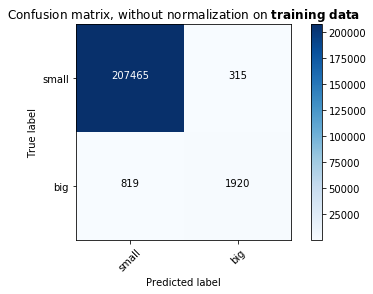

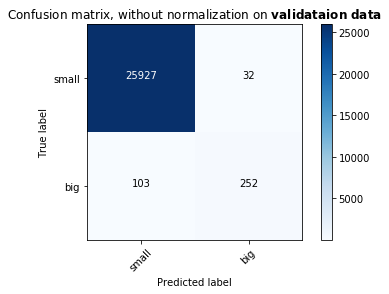

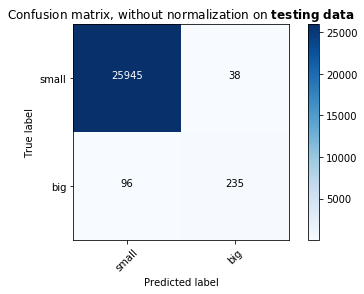

In [125]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
model_name = "model3_3layer128relu.h5"
model = load_model('../result/models/' + model_name)

y_pred_1 = model.predict(X_train)
y_pred_1 = y_pred_1.round()
y_pred_2 = model.predict(X_val)
y_pred_2 = y_pred_2.round()
y_pred_3 = model.predict(X_test)
y_pred_3 = y_pred_3.round()

cnf_matrix_1 = confusion_matrix(y_train, y_pred_1)
cnf_matrix_2 = confusion_matrix(y_val, y_pred_2)
cnf_matrix_3 = confusion_matrix(y_test, y_pred_3)
#np.set_printoptions(precision=2)
class_names = ['small', 'big']


plt.figure(1)
plot_confusion_matrix(cnf_matrix_1, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{training}$' +' '+ r'$\bf{data}$')

plt.figure(2)
plot_confusion_matrix(cnf_matrix_2, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{validataion}$' +' '+ r'$\bf{data}$')

plt.figure(3)
plot_confusion_matrix(cnf_matrix_3, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{testing}$' +' '+ r'$\bf{data}$')

plt.show()

# result 0
But we can find that the dataset is not trainable.  
The DNN can't figure out if a cloud is big or not.  
Even if we use the training data to predict, the DNN can not figure out if a cloud is big or not.  
So we decided to do some preprocessing in this dataset.

# Method 1
by weting.c

DELETE the cloud that cloud base height is higher than 2.5km

In [105]:
train_data_m1 = train_data[train_data[:,4]<2500]

In [106]:
X_train_m1 = train_data_m1[:,[2,3,4,6]]
X_train_m1 = sc.fit_transform(X_train_m1)
y_train_m1 = train_data_m1[:,5]
y_train_m1 = y_train_m1 >= 5

In [111]:
def main_m1(model_name):
    csv_dir = '../result/csv_history_m1/'
    if not os.path.isdir(csv_dir):
        os.mkdir(csv_dir)
    model_dir = '../result/models_m1/'
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
    csv_path = csv_dir+ '/test8.csv'
    model_path = model_dir + model_name
    model = build_nn_4_input()
    train(model, X_train_m1, X_val, y_train_m1, y_val, model_path, csv_path)
    print('\n\n done!!!!!!!')   

In [112]:
main_m1(model_name)

Build model!
Training...
Train on 83685 samples, validate on 26314 samples
Epoch 1/2000
82432/83685 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9830
Epoch 00001: acc improved from -inf to 0.98302, saving model to ../result/models_m1//model8_selu.h5
83685/83685 [==============================] - 4s 43us/step - loss: 0.0450 - acc: 0.9830 - val_loss: 0.0702 - val_acc: 0.9865
Epoch 2/2000
80896/83685 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9860
Epoch 00002: acc improved from 0.98302 to 0.98603, saving model to ../result/models_m1//model8_selu.h5
83685/83685 [==============================] - 2s 21us/step - loss: 0.0369 - acc: 0.9860 - val_loss: 0.0442 - val_acc: 0.9831
Epoch 3/2000
83584/83685 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9858
Epoch 00003: acc did not improve
83685/83685 [==============================] - 2s 23us/step - loss: 0.0356 - acc: 0.9858 - val_loss: 0.0525 - val_acc: 0.9799
Epoch 4/2000
81280/8

Epoch 30/2000
82816/83685 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9870
Epoch 00030: acc did not improve
83685/83685 [==============================] - 2s 22us/step - loss: 0.0316 - acc: 0.9870 - val_loss: 0.0582 - val_acc: 0.9783
Epoch 31/2000
83328/83685 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9869
Epoch 00031: acc did not improve
83685/83685 [==============================] - 2s 24us/step - loss: 0.0315 - acc: 0.9869 - val_loss: 0.0595 - val_acc: 0.9783
Epoch 32/2000
82816/83685 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9867
Epoch 00032: acc did not improve
83685/83685 [==============================] - 2s 22us/step - loss: 0.0316 - acc: 0.9866 - val_loss: 0.0473 - val_acc: 0.9817
Epoch 33/2000
82944/83685 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9871
Epoch 00033: acc did not improve
83685/83685 [==============================] - 2s 22us/step - loss: 0.0315 - acc: 0.9871 - val_los

Confusion matrix, without normalization
[[80338   309]
 [  528  2186]]
Confusion matrix, without normalization
[[25031   928]
 [   34   321]]
Confusion matrix, without normalization
[[24979  1004]
 [   26   305]]


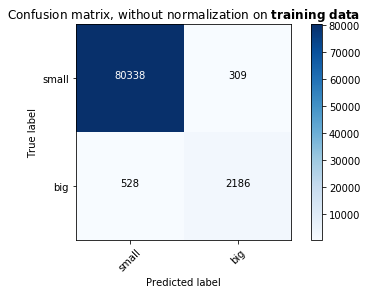

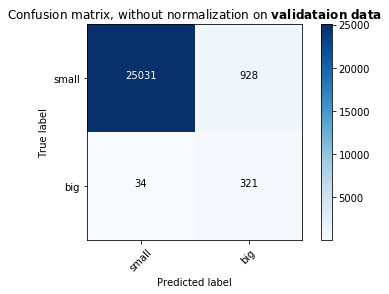

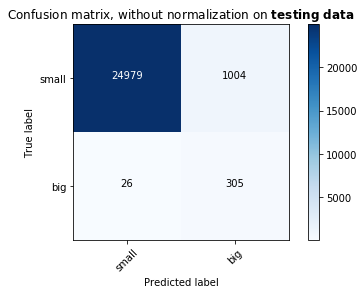

In [107]:
model = load_model('../result/models_m1/' + model_name)

y_pred_1 = model.predict(X_train_m1)
y_pred_1 = y_pred_1.round()
y_pred_2 = model.predict(X_val)
y_pred_2 = y_pred_2.round()
y_pred_3 = model.predict(X_test)
y_pred_3 = y_pred_3.round()

cnf_matrix_1 = confusion_matrix(y_train_m1, y_pred_1)
cnf_matrix_2 = confusion_matrix(y_val, y_pred_2)
cnf_matrix_3 = confusion_matrix(y_test, y_pred_3)

class_names = ['small', 'big']


plt.figure(1)
plot_confusion_matrix(cnf_matrix_1, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{training}$' +' '+ r'$\bf{data}$')

plt.figure(2)
plot_confusion_matrix(cnf_matrix_2, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{validataion}$' +' '+ r'$\bf{data}$')

plt.figure(3)
plot_confusion_matrix(cnf_matrix_3, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{testing}$' +' '+ r'$\bf{data}$')

plt.show()

# Result 1
Our algorithm still can't figure out the cloud is big or not.  

# Method 2
ignore the cloud which core number is zero on training data

In [108]:
train_data_m2 = train_data[train_data[:,5]>0]

In [109]:
X_train_m2 = train_data_m2[:,[2,3,4,6]]
X_train_m2 = sc.fit_transform(X_train_m2)
y_train_m2 = train_data_m2[:,5]
y_train_m2 = y_train_m2 >= 5

In [116]:
def main_m2(model_name):
    csv_dir = '../result/csv_history_m2/'
    if not os.path.isdir(csv_dir):
        os.mkdir(csv_dir)
    model_dir = '../result/models_m2/'
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
    csv_path = csv_dir+ '/test8.csv'
    model_path = model_dir + model_name
    model = build_nn_4_input()
    train(model, X_train_m2, X_val, y_train_m2, y_val, model_path, csv_path)
    print('\n\n done!!!!!!!')   

In [117]:
main_m2(model_name)

Build model!
Training...
Train on 37824 samples, validate on 26314 samples
Epoch 1/2000
36736/37824 [============================>.] - ETA: 0s - loss: 0.0985 - acc: 0.9641
Epoch 00001: acc improved from -inf to 0.96426, saving model to ../result/models_m2//model8_selu.h5
37824/37824 [==============================] - 3s 73us/step - loss: 0.0982 - acc: 0.9643 - val_loss: 0.0822 - val_acc: 0.9717
Epoch 2/2000
36096/37824 [===========================>..] - ETA: 0s - loss: 0.0843 - acc: 0.9679
Epoch 00002: acc improved from 0.96426 to 0.96822, saving model to ../result/models_m2//model8_selu.h5
37824/37824 [==============================] - 1s 24us/step - loss: 0.0839 - acc: 0.9682 - val_loss: 0.0840 - val_acc: 0.9742
Epoch 3/2000
36480/37824 [===========================>..] - ETA: 0s - loss: 0.0828 - acc: 0.9688
Epoch 00003: acc improved from 0.96822 to 0.96896, saving model to ../result/models_m2//model8_selu.h5
37824/37824 [==============================] - 1s 26us/step - loss: 0.0823 -

36224/37824 [===========================>..] - ETA: 0s - loss: 0.0718 - acc: 0.9710
Epoch 00061: acc did not improve
37824/37824 [==============================] - 1s 26us/step - loss: 0.0714 - acc: 0.9711 - val_loss: 0.0982 - val_acc: 0.9587
Epoch 62/2000
36224/37824 [===========================>..] - ETA: 0s - loss: 0.0713 - acc: 0.9710
Epoch 00062: acc did not improve
37824/37824 [==============================] - 1s 24us/step - loss: 0.0712 - acc: 0.9710 - val_loss: 0.0807 - val_acc: 0.9798
Epoch 63/2000
37632/37824 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9715
Epoch 00063: acc did not improve
37824/37824 [==============================] - 1s 36us/step - loss: 0.0705 - acc: 0.9715 - val_loss: 0.0890 - val_acc: 0.9788
Epoch 64/2000
37504/37824 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9711
Epoch 00064: acc did not improve
37824/37824 [==============================] - 2s 49us/step - loss: 0.0703 - acc: 0.9713 - val_loss: 0.0677 - va

Epoch 92/2000
36736/37824 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9712
Epoch 00092: acc did not improve
37824/37824 [==============================] - 1s 25us/step - loss: 0.0701 - acc: 0.9709 - val_loss: 0.1389 - val_acc: 0.9291
Epoch 93/2000
36096/37824 [===========================>..] - ETA: 0s - loss: 0.0697 - acc: 0.9714
Epoch 00093: acc did not improve
37824/37824 [==============================] - 1s 24us/step - loss: 0.0698 - acc: 0.9713 - val_loss: 0.1210 - val_acc: 0.9512
Epoch 94/2000
37376/37824 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9718
Epoch 00094: acc did not improve
37824/37824 [==============================] - 1s 29us/step - loss: 0.0695 - acc: 0.9719 - val_loss: 0.0721 - val_acc: 0.9793
Epoch 95/2000
36608/37824 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9717
Epoch 00095: acc did not improve
37824/37824 [==============================] - 1s 24us/step - loss: 0.0692 - acc: 0.9719 - val_los

Epoch 123/2000
35840/37824 [===========================>..] - ETA: 0s - loss: 0.0690 - acc: 0.9712
Epoch 00123: acc did not improve
37824/37824 [==============================] - 1s 29us/step - loss: 0.0688 - acc: 0.9714 - val_loss: 0.1173 - val_acc: 0.9471
Epoch 124/2000
37504/37824 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9719
Epoch 00124: acc did not improve
37824/37824 [==============================] - 1s 38us/step - loss: 0.0684 - acc: 0.9719 - val_loss: 0.1230 - val_acc: 0.9301
Epoch 125/2000
37120/37824 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9718
Epoch 00125: acc did not improve
37824/37824 [==============================] - 2s 58us/step - loss: 0.0690 - acc: 0.9720 - val_loss: 0.1673 - val_acc: 0.9273
Epoch 126/2000
35840/37824 [===========================>..] - ETA: 0s - loss: 0.0683 - acc: 0.9728
Epoch 00126: acc did not improve
37824/37824 [==============================] - 1s 29us/step - loss: 0.0691 - acc: 0.9722 - val

Epoch 154/2000
36224/37824 [===========================>..] - ETA: 0s - loss: 0.0682 - acc: 0.9719
Epoch 00154: acc did not improve
37824/37824 [==============================] - 1s 31us/step - loss: 0.0681 - acc: 0.9720 - val_loss: 0.0994 - val_acc: 0.9642
Epoch 155/2000
37248/37824 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9721
Epoch 00155: acc did not improve
37824/37824 [==============================] - 1s 25us/step - loss: 0.0677 - acc: 0.9721 - val_loss: 0.1272 - val_acc: 0.9301
Epoch 156/2000
37376/37824 [============================>.] - ETA: 0s - loss: 0.0680 - acc: 0.9724
Epoch 00156: acc did not improve
37824/37824 [==============================] - 1s 25us/step - loss: 0.0680 - acc: 0.9725 - val_loss: 0.1164 - val_acc: 0.9498
Epoch 157/2000
37632/37824 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9723
Epoch 00157: acc did not improve
37824/37824 [==============================] - 1s 25us/step - loss: 0.0678 - acc: 0.9723 - val

Confusion matrix, without normalization
[[34592   356]
 [  474  2265]]
Confusion matrix, without normalization
[[21184  4775]
 [   37   318]]
Confusion matrix, without normalization
[[21168  4815]
 [   31   300]]


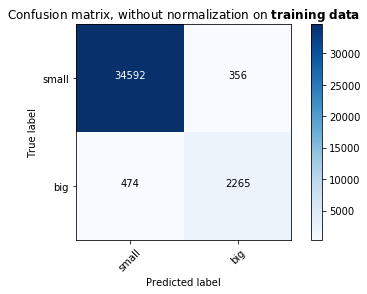

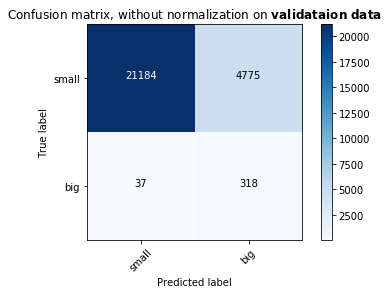

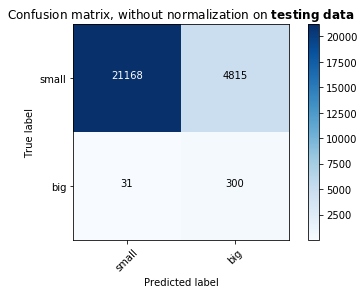

In [110]:
model = load_model('../result/models_m2/' + model_name)

y_pred_1 = model.predict(X_train_m2)
y_pred_1 = y_pred_1.round()
y_pred_2 = model.predict(X_val)
y_pred_2 = y_pred_2.round()
y_pred_3 = model.predict(X_test)
y_pred_3 = y_pred_3.round()

cnf_matrix_1 = confusion_matrix(y_train_m2, y_pred_1)
cnf_matrix_2 = confusion_matrix(y_val, y_pred_2)
cnf_matrix_3 = confusion_matrix(y_test, y_pred_3)

class_names = ['small', 'big']


plt.figure(1)
plot_confusion_matrix(cnf_matrix_1, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{training}$' +' '+ r'$\bf{data}$')

plt.figure(2)
plot_confusion_matrix(cnf_matrix_2, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{validataion}$' +' '+ r'$\bf{data}$')

plt.figure(3)
plot_confusion_matrix(cnf_matrix_3, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{testing}$' +' '+ r'$\bf{data}$')

plt.show()

# Method 3
generate new big cloud to balance this case on training data

###
X_BIG = X_train[y_train == 1]
X_SMALL = X_train[y_train == 0]
print(X_BIG.shape, X_SMALL.shape)
need = int(207783/4 - 2736)
print(need)

d = dict()
for i in range(1,19):
    d['data%d' % i] = X_BIG * 0.0001 *i + X_BIG

for key in d:
    X_BIG = np.concatenate((X_BIG, d[key]), axis=0)
    print(X_BIG.shape)

In [52]:
X_train_m3 = np.load('../data/x_m3_generate.npy')
X_train_m3 = sc.fit_transform(X_train_m3)
y_train_m3 = np.load('../data/y_m3_generate.npy')

In [114]:
def main_m3(model_name):
    csv_dir = '../result/csv_history_m3/'
    if not os.path.isdir(csv_dir):
        os.mkdir(csv_dir)
    model_dir = '../result/models_m3/'
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
    csv_path = csv_dir+ '/test1.csv'
    model_path = model_dir + model_name
    model = build_nn_4_input()
    train(model, X_train_m3, X_val, y_train_m3, y_val, model_path, csv_path)
    print('\n\n done!!!!!!!')   

In [115]:
main_m3(model_name)

Build model!
Training...
Train on 260878 samples, validate on 26314 samples
Epoch 1/2000
259200/260878 [============================>.] - ETA: 0s - loss: 0.0663 - acc: 0.9745
Epoch 00001: val_acc improved from -inf to 0.73246, saving model to ../result/models_m3//model8.h5
260878/260878 [==============================] - 5s 18us/step - loss: 0.0662 - acc: 0.9745 - val_loss: 0.8445 - val_acc: 0.7325
Epoch 2/2000
260480/260878 [============================>.] - ETA: 0s - loss: 0.0537 - acc: 0.9793
Epoch 00002: val_acc did not improve
260878/260878 [==============================] - 4s 16us/step - loss: 0.0536 - acc: 0.9793 - val_loss: 0.8884 - val_acc: 0.7081
Epoch 3/2000
258176/260878 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9805
Epoch 00003: val_acc improved from 0.73246 to 0.75120, saving model to ../result/models_m3//model8.h5
260878/260878 [==============================] - 4s 16us/step - loss: 0.0509 - acc: 0.9805 - val_loss: 0.8729 - val_acc: 0.7512
Epoch

Epoch 28/2000
257920/260878 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9862
Epoch 00028: val_acc did not improve
260878/260878 [==============================] - 4s 16us/step - loss: 0.0371 - acc: 0.9862 - val_loss: 0.3162 - val_acc: 0.9260
Epoch 29/2000
260480/260878 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9864
Epoch 00029: val_acc did not improve
260878/260878 [==============================] - 4s 15us/step - loss: 0.0369 - acc: 0.9864 - val_loss: 0.3791 - val_acc: 0.9208
Epoch 30/2000
260608/260878 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9863
Epoch 00030: val_acc did not improve
260878/260878 [==============================] - 4s 15us/step - loss: 0.0371 - acc: 0.9863 - val_loss: 0.3360 - val_acc: 0.9246
Epoch 31/2000
260608/260878 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9865
Epoch 00031: val_acc did not improve
260878/260878 [==============================] - 4s 15us/step - loss

Epoch 58/2000
258304/260878 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9899
Epoch 00058: val_acc did not improve
260878/260878 [==============================] - 4s 15us/step - loss: 0.0298 - acc: 0.9900 - val_loss: 0.5166 - val_acc: 0.9197
Epoch 59/2000
257792/260878 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9903
Epoch 00059: val_acc did not improve
260878/260878 [==============================] - 4s 15us/step - loss: 0.0293 - acc: 0.9903 - val_loss: 0.5205 - val_acc: 0.9178
Epoch 60/2000
257792/260878 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9905
Epoch 00060: val_acc did not improve
260878/260878 [==============================] - 4s 15us/step - loss: 0.0287 - acc: 0.9905 - val_loss: 0.5715 - val_acc: 0.9174
Epoch 61/2000
257920/260878 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9902
Epoch 00061: val_acc did not improve
260878/260878 [==============================] - 4s 15us/step - loss

Confusion matrix, without normalization
[[205973   1776]
 [  1664  51465]]
Confusion matrix, without normalization
[[24244  1715]
 [   15   340]]
Confusion matrix, without normalization
[[24212  1771]
 [    8   323]]


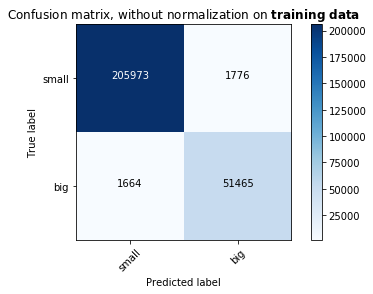

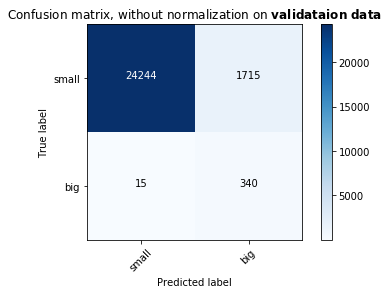

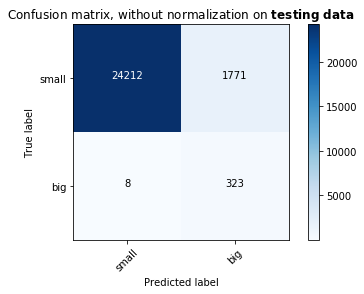

In [120]:
model_name = "/model8.h5"
model = load_model('../result/models_m3/' + model_name)

y_pred_1 = model.predict(X_train_m3)
y_pred_1 = y_pred_1.round()
y_pred_2 = model.predict(X_val)
y_pred_2 = y_pred_2.round()
y_pred_3 = model.predict(X_test)
y_pred_3 = y_pred_3.round()

cnf_matrix_1 = confusion_matrix(y_train_m3, y_pred_1)
cnf_matrix_2 = confusion_matrix(y_val, y_pred_2)
cnf_matrix_3 = confusion_matrix(y_test, y_pred_3)

class_names = ['small', 'big']


plt.figure(1)
plot_confusion_matrix(cnf_matrix_1, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{training}$' +' '+ r'$\bf{data}$')

plt.figure(2)
plot_confusion_matrix(cnf_matrix_2, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{validataion}$' +' '+ r'$\bf{data}$')

plt.figure(3)
plot_confusion_matrix(cnf_matrix_3, classes=class_names,
                      title='Confusion matrix, without normalization on '+ r'$\bf{testing}$' +' '+ r'$\bf{data}$')

plt.show()

In [86]:
(1-0.9952)*(207749+49768+3361)

1252.214400000007

In [94]:
X_train_m3[y_train_m3==1].shape

(53129, 4)

In [95]:
AA = model.predict(X_train_m3[y_train_m3==1],batch_size=128)

In [101]:
AA = AA.round()
print(AA[AA==1].shape)

(52955,)


In [74]:
model.evaluate(X_train_m3,y_train_m3)

260878/260878 [==============================] - 5s 21us/step


[0.020282254664057506, 0.994085357906761]

In [77]:
print(y_pred_1[y_pred_1==1].shape)

(3361,)


In [78]:
y_train_m3[y_train_m3==1].shape

(53129,)